In [1]:
import os
import logging
import importlib
importlib.reload(logging) # see https://stackoverflow.com/a/21475297/1469195
log = logging.getLogger()
log.setLevel('INFO')
import sys

logging.basicConfig(format='%(asctime)s %(levelname)s |: %(message)s',
                     level=logging.INFO, stream=sys.stdout)
import mne
from mne.io import concatenate_raws
import matplotlib.pyplot as plt
from scipy import signal
from sklearn import preprocessing
import numpy as np
from torchsummary import summary
import torch

In [6]:
point = 200
ranndom_size = 20
X_pseudo_test = np.zeros((0, 19, 306))
X_pseudo_train = np.zeros((0, 19, 306))
X_word_test = np.zeros((0, 19, 306))
X_word_train = np.zeros((0, 19, 306))
for filename in os.listdir('.'):
    if '_exp1.set' in filename:
        print(filename)
        f = mne.io.read_epochs_eeglab(filename)
        syg = f.get_data()
        syg_train_mean = np.zeros(syg[:point,:,:].shape)
        for i in range(syg[:point,:,:].shape[0]):
            x = np.random.randint(syg[:point,:,:].shape[0], size=ranndom_size)
            syg_train_mean[i,:,:] = np.mean(syg[:point,:,:][x,:,:], axis=0)
        X_pseudo_train = np.concatenate((X_pseudo_train, syg_train_mean), axis = 0)
        syg_train_mean = np.zeros(syg[:point,:,:].shape)
        syg_test_mean = np.zeros(syg[point:,:,:].shape)
        for i in range(syg[point:,:,:].shape[0]):
            x = np.random.randint(syg[point:,:,:].shape[0], size=ranndom_size)
            syg_test_mean[i,:,:] = np.mean(syg[point:,:,:][x,:,:], axis=0)
        X_pseudo_test = np.concatenate((X_pseudo_test, syg_test_mean), axis = 0)
#         X_pseudo_test = np.concatenate((X_pseudo_test, syg[point:,:,:]), axis = 0)
    if '_exp2.set' in filename:
        print(filename)
        f = mne.io.read_epochs_eeglab(filename)
        syg = f.get_data()
        syg_mean = np.zeros(syg.shape)
        syg_train_mean = np.zeros(syg[:point,:,:].shape)
        for i in range(syg[:point,:,:].shape[0]):
            x = np.random.randint(syg[:point,:,:].shape[0], size=ranndom_size)
            syg_train_mean[i,:,:] = np.mean(syg[:point,:,:][x,:,:], axis=0)
        X_word_train = np.concatenate((X_word_train, syg_train_mean), axis = 0)
        syg_train_mean = np.zeros(syg[:point,:,:].shape)
        syg_test_mean = np.zeros(syg[point:,:,:].shape)
        for i in range(syg[point:,:,:].shape[0]):
            x = np.random.randint(syg[point:,:,:].shape[0], size=ranndom_size)
            syg_test_mean[i,:,:] = np.mean(syg[point:,:,:][x,:,:], axis=0)
        X_word_test = np.concatenate((X_word_test, syg_test_mean), axis = 0)
#         X_word_test = np.concatenate((X_word_test, syg[point:,:,:]), axis = 0)

B21_exp1.set
Extracting parameters from B21_exp1.set...
283 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
B31_exp1.set
Extracting parameters from B31_exp1.set...
308 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
B36_exp1.set
Extracting parameters from B36_exp1.set...
292 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
B37_exp2.set
Extracting parameters from B37_exp2.set...
331 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
B27_exp2.set
Extracting parameters from B27_exp2.set...
263 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
B35_exp2.set
Extracting parameters from B35_exp2.set...
296 matching events found
No baseline correction applied
Not setting metadata
0 projection ite

In [8]:
np.save('X_pseudo_test_average.npy', X_pseudo_test)
np.save('X_word_test_average.npy', X_word_test)
np.save('X_pseudo_train_average.npy', X_pseudo_train)
np.save('X_word_test_average.npy', X_word_train)

In [2]:
X_pseudo_test = np.load('X_pseudo_test_average.npy', )
X_word_test = np.load('X_word_test_average.npy', )
X_pseudo_train = np.load('X_pseudo_train_average.npy', )
X_word_train = np.load('X_word_test_average.npy', )

In [3]:
X_test = np.concatenate((X_word_test,X_pseudo_test))
X_test = (X_test * 1e8).astype(np.float32)
y_test = np.zeros(X_test.shape[0])
y_test[:X_word_test.shape[0]] = 1
ind = np.arange(X_test.shape[0])
np.random.shuffle(ind)
X_test = X_test[ind,:,:]
y_test = y_test[ind]

In [5]:
X_train = np.concatenate((X_word_train,X_pseudo_train))
X_train = (X_train * 1e8).astype(np.float32)
y_train = np.zeros(X_train.shape[0])
y_train[:X_word_train.shape[0]] = 1
ind = np.arange(X_train.shape[0])
np.random.shuffle(ind)
X_train = X_train[ind,:,:]
y_train = y_train[ind]

In [6]:
y_test = y_test.astype(np.int64)
y_train = y_train.astype(np.int64)

In [7]:
print(f'X_train; {X_train.shape}')
print(f'X_test; {X_test.shape}')
print(f'y_test; {y_test.shape}')
print(f'y_train; {y_train.shape}')

X_train; (12000, 19, 306)
X_test; (8903, 19, 306)
y_test; (8903,)
y_train; (12000,)


In [8]:
from braindecode.datautil.signal_target import SignalAndTarget

train_set = SignalAndTarget(X_train[:10000], y=y_train[:10000])
valid_set = SignalAndTarget(X_test[:5000], y=y_test[:5000])

In [9]:
from braindecode.models.shallow_fbcsp import ShallowFBCSPNet
from torch import nn
from braindecode.torch_ext.util import set_random_seeds

# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.
cuda = True
set_random_seeds(seed=20170629, cuda=cuda)
n_classes = 2
in_chans = train_set.X.shape[1]
# final_conv_length = auto ensures we only get a single output in the time dimension
model = ShallowFBCSPNet(in_chans=in_chans, n_classes=n_classes,
                        input_time_length=train_set.X.shape[2],
                        final_conv_length='auto')
if cuda:
    model.cuda()

In [10]:
from braindecode.torch_ext.optimizers import AdamW
import torch.nn.functional as F
optimizer = AdamW(model.parameters(), lr=1*0.01, weight_decay=0.5*0.001) # these are good values for the deep model
# optimizer = AdamW(model.parameters(), lr=0.0625 * 0.01, weight_decay=0)
model.compile(loss=F.nll_loss, optimizer=optimizer, iterator_seed=1,)

In [11]:
model.fit(train_set.X, train_set.y, epochs=30, batch_size=64, scheduler='cosine',
         validation_data=(valid_set.X, valid_set.y),)

2020-04-23 19:40:12,723 INFO |: Run until first stop...
2020-04-23 19:40:16,007 INFO |: Epoch 0
2020-04-23 19:40:16,008 INFO |: train_loss                3.42960
2020-04-23 19:40:16,008 INFO |: valid_loss                4.61557
2020-04-23 19:40:16,009 INFO |: train_misclass            0.49880
2020-04-23 19:40:16,010 INFO |: valid_misclass            0.67000
2020-04-23 19:40:16,010 INFO |: runtime                   0.00000
2020-04-23 19:40:16,011 INFO |: 
2020-04-23 19:40:20,460 INFO |: Time only for training updates: 4.45s
2020-04-23 19:40:23,714 INFO |: Epoch 1
2020-04-23 19:40:23,715 INFO |: train_loss                0.44370
2020-04-23 19:40:23,715 INFO |: valid_loss                0.41197
2020-04-23 19:40:23,716 INFO |: train_misclass            0.20620
2020-04-23 19:40:23,716 INFO |: valid_misclass            0.18940
2020-04-23 19:40:23,717 INFO |: runtime                   7.73695
2020-04-23 19:40:23,717 INFO |: 
2020-04-23 19:40:28,176 INFO |: Time only for training updates: 4.46

KeyboardInterrupt: 

In [11]:
model.epochs_df

,train_loss,valid_loss,train_misclass,valid_misclass,runtime
0,3.445277,4.676670,0.5003,0.6794,0.000000
1,0.541310,0.360864,0.2464,0.1566,5.152881
2,0.327378,0.371947,0.1398,0.1658,5.601719
3,0.332560,0.214353,0.1387,0.0792,4.555389
4,0.223882,0.235372,0.0905,0.0940,4.459079
5,0.272388,0.350374,0.1188,0.1566,4.888277
6,0.180928,0.169537,0.0725,0.0670,4.996127
7,0.153147,0.145738,0.0629,0.0556,4.591013
8,0.170076,0.167349,0.0690,0.0650,4.964906
9,0.135464,0.134732,0.0529,0.0504,5.067991


In [31]:
torch.save(model.network.state_dict(), 'model_mean')

In [33]:
model.network

Sequential(
  (dimshuffle): Expression(expression=_transpose_time_to_spat)
  (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d(40, 40, kernel_size=(1, 19), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin): Expression(expression=square)
  (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0)
  (pool_nonlin): Expression(expression=safe_log)
  (drop): Dropout(p=0.5, inplace=False)
  (conv_classifier): Conv2d(40, 2, kernel_size=(14, 1), stride=(1, 1))
  (softmax): LogSoftmax()
  (squeeze): Expression(expression=_squeeze_final_output)
)

In [37]:
from braindecode.visualization import input_windows
import matplotlib.pyplot as plt

In [52]:
input_windows.calc_receptive_field_size(model.network,2,8)

array([32,  8])

In [19]:
test_set = SignalAndTarget(X_test[5000:5120], y=y_test[5000:5120])

model.evaluate(test_set.X, test_set.y)

{'loss': 0.0763733983039856,
 'misclass': 0.025000000000000022,
 'runtime': 0.00036787986755371094}

In [29]:
print(model.network)

Sequential(
  (dimshuffle): Expression(expression=_transpose_time_to_spat)
  (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d(40, 40, kernel_size=(1, 19), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin): Expression(expression=square)
  (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0)
  (pool_nonlin): Expression(expression=safe_log)
  (drop): Dropout(p=0.5, inplace=False)
  (conv_classifier): Conv2d(40, 2, kernel_size=(14, 1), stride=(1, 1))
  (softmax): LogSoftmax()
  (squeeze): Expression(expression=_squeeze_final_output)
)


In [53]:
w = list(model.network.parameters())

In [81]:
tensor_test = np.array(w[1].data.cpu())

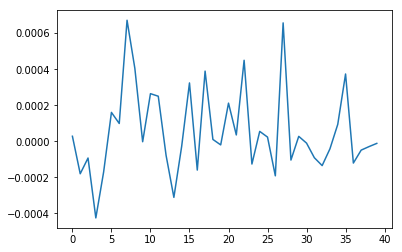

In [82]:
plt.plot(tensor_test)

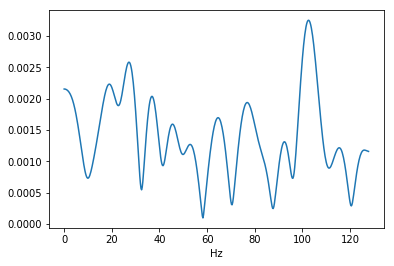

In [83]:
import scipy.signal as ss
b = tensor_test
f, h0= ss.freqz(b, a=1, worN=512, whole=False,  fs=256)


plt.figure()
plt.plot(f, abs(h0))
plt.xlabel('Hz')
plt.show()

In [8]:
from braindecode.models.deep4 import Deep4Net
from torch import nn
from braindecode.torch_ext.util import set_random_seeds
from braindecode.models.util import to_dense_prediction_model

# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.
cuda = True
set_random_seeds(seed=20170629, cuda=cuda)

# This will determine how many crops are processed in parallel
input_time_length = 306
# final_conv_length determines the size of the receptive field of the ConvNet
model = Deep4Net(in_chans=19, n_classes=2, input_time_length=input_time_length,
                 filter_length_3=5, filter_length_4=5,
                 pool_time_stride=2,
                 stride_before_pool=True,
                        final_conv_length=1)
if cuda:
    model.cuda()

In [9]:
from braindecode.torch_ext.optimizers import AdamW
import torch.nn.functional as F
optimizer = AdamW(model.parameters(), lr=1*0.01, weight_decay=0.5*0.001) # these are good values for the deep model
model.compile(loss=F.nll_loss, optimizer=optimizer,  iterator_seed=1, cropped=True)

In [10]:
input_time_length = 306
model.fit(train_set.X, train_set.y, epochs=20, batch_size=64, scheduler='cosine',
          input_time_length=input_time_length,
         validation_data=(valid_set.X, valid_set.y),)

2020-03-31 13:20:29,575 INFO |: Run until first stop...
2020-03-31 13:20:33,785 INFO |: Epoch 0
2020-03-31 13:20:33,786 INFO |: train_loss                8.31650
2020-03-31 13:20:33,786 INFO |: valid_loss                5.96342
2020-03-31 13:20:33,787 INFO |: train_misclass            0.48310
2020-03-31 13:20:33,788 INFO |: valid_misclass            0.35160
2020-03-31 13:20:33,790 INFO |: runtime                   0.00000
2020-03-31 13:20:33,791 INFO |: 
2020-03-31 13:20:50,556 INFO |: Time only for training updates: 16.23s
2020-03-31 13:20:55,173 INFO |: Epoch 1
2020-03-31 13:20:55,173 INFO |: train_loss                0.65718
2020-03-31 13:20:55,174 INFO |: valid_loss                0.69437
2020-03-31 13:20:55,174 INFO |: train_misclass            0.36200
2020-03-31 13:20:55,174 INFO |: valid_misclass            0.44300
2020-03-31 13:20:55,178 INFO |: runtime                   20.98089
2020-03-31 13:20:55,180 INFO |: 
2020-03-31 13:21:12,516 INFO |: Time only for training updates: 16

In [13]:
test_set = SignalAndTarget(X_test[5000:], y=y_test[5000:])

model.evaluate(test_set.X, test_set.y)

{'loss': 0.08186265081167221,
 'misclass': 0.030745580322828592,
 'runtime': 0.0003867149353027344}

In [12]:
print(model.predict_classes(test_set.X))

[1 0 1 ... 1 1 1]


In [13]:
print(test_set.y)

[0 0 1 ... 1 1 1]


In [24]:
import torch as torch
input_time_length = X_test.shape[2]
from braindecode.datautil.iterators import CropsFromTrialsIterator
from braindecode.torch_ext.util import np_to_var
test_input = np_to_var(np.ones((2, 19, input_time_length, 1), dtype=np.float32))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if cuda:
    test_input = test_input.to(device)
out = model.network(test_input)
n_preds_per_input = out.cpu().data.numpy().shape[2]
iterator = CropsFromTrialsIterator(batch_size=30,input_time_length=input_time_length,
                                  n_preds_per_input=n_preds_per_input)

train_batches = list(iterator.get_batches(train_set, shuffle=False))
train_X_batches = np.concatenate(list(zip(*train_batches))[0])
from torch import nn
from braindecode.torch_ext.util import var_to_np
import torch as th
new_model = nn.Sequential()
for name, module in model.network.named_children():
    if name == 'softmax': break
    new_model.add_module(name, module)

new_model.eval();
pred_fn = lambda x: var_to_np(th.mean(new_model(np_to_var(x).cuda())[:,:,:,0], dim=2, keepdim=False))

from braindecode.visualization.perturbation import compute_amplitude_prediction_correlations


amp_pred_corrs = compute_amplitude_prediction_correlations(pred_fn, train_X_batches, n_iterations=12,
                                         batch_size=30)

2020-03-31 13:36:33,348 INFO |: Compute original predictions...
2020-03-31 13:36:36,844 INFO |: Iteration 0...
2020-03-31 13:36:36,845 INFO |: Sample perturbation...
2020-03-31 13:36:37,807 INFO |: Compute perturbed complex inputs...
2020-03-31 13:36:38,899 INFO |: Compute perturbed real inputs...
2020-03-31 13:36:39,845 INFO |: Compute new predictions...
2020-03-31 13:36:41,828 INFO |: Layer 0...
2020-03-31 13:36:41,829 INFO |: Compute activation difference...
2020-03-31 13:36:41,830 INFO |: Compute correlation...
2020-03-31 13:36:42,162 INFO |: Iteration 1...
2020-03-31 13:36:42,163 INFO |: Sample perturbation...
2020-03-31 13:36:43,141 INFO |: Compute perturbed complex inputs...
2020-03-31 13:36:44,227 INFO |: Compute perturbed real inputs...
2020-03-31 13:36:45,175 INFO |: Compute new predictions...
2020-03-31 13:36:46,863 INFO |: Layer 0...
2020-03-31 13:36:46,863 INFO |: Compute activation difference...
2020-03-31 13:36:46,864 INFO |: Compute correlation...
2020-03-31 13:36:47,16

B01_exp1.set
Extracting parameters from B01_exp1.set...
339 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
['O1', 'O2', 'P7', 'P3', 'Pz', 'P4', 'P8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Fp1', 'Fp2']
[(-0.060170510847620935, -0.7347489792844866), (0.060170510847620935, -0.7347489792844866), (-0.5439282932204211, -0.543928293220421), (-0.27777777777777773, -0.392837100659193), (0.0, -0.3523015256659762), (0.27777777777777773, -0.392837100659193), (0.5439282932204211, -0.543928293220421), (-0.7692307692307692, 0.0), (-0.3523015256659762, 0.0), (0.0, 0.0), (0.3523015256659762, 0.0), (0.7692307692307692, 0.0), (-0.5439282932204211, 0.543928293220421), (-0.27777777777777773, 0.392837100659193), (0.0, 0.3523015256659762), (0.27777777777777773, 0.392837100659193), (0.5439282932204211, 0.543928293220421), (-0.14299932944506125, 0.7329903809028484), (0.14299932944506125, 0.7329903809028484)]


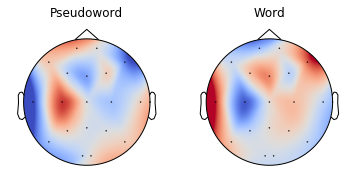

In [25]:
for filename in os.listdir('.'):
    if 'B01_exp1.set' in filename:
        print(filename)
        f = mne.io.read_epochs_eeglab(filename)
import torch
from braindecode.datautil.iterators import CropsFromTrialsIterator
from braindecode.torch_ext.util import np_to_var
test_input = np_to_var(np.ones((2, 19, input_time_length, 1), dtype=np.float32))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if cuda:
    test_input = test_input.to(device)
out = model.network(test_input)
n_preds_per_input = out.cpu().data.numpy().shape[2]
iterator = CropsFromTrialsIterator(batch_size=30,input_time_length=input_time_length,
                                  n_preds_per_input=n_preds_per_input)

train_batches = list(iterator.get_batches(train_set, shuffle=False))
train_X_batches = np.concatenate(list(zip(*train_batches))[0])

from torch import nn
from braindecode.torch_ext.util import var_to_np
import torch as th
new_model = nn.Sequential()
for name, module in model.network.named_children():
    if name == 'softmax': break
    new_model.add_module(name, module)

new_model.eval();
pred_fn = lambda x: var_to_np(th.mean(new_model(np_to_var(x).cuda())[:,:,:,0], dim=2, keepdim=False))

from torch import nn
from braindecode.torch_ext.util import var_to_np
import torch as th
new_model = nn.Sequential()
for name, module in model.network.named_children():
    if name == 'softmax': break
    new_model.add_module(name, module)

new_model.eval();
pred_fn = lambda x: var_to_np(th.mean(new_model(np_to_var(x).cuda())[:,:,:,0], dim=2, keepdim=False))

fs = 256
freqs = np.fft.rfftfreq(train_X_batches.shape[2], d=1.0/fs)
start_freq = 1
stop_freq = 31

i_start = np.searchsorted(freqs,start_freq)
i_stop = np.searchsorted(freqs, stop_freq) + 1

freq_corr = np.mean(amp_pred_corrs[:,i_start:i_stop], axis=1)

from braindecode.datasets.sensor_positions import get_channelpos, CHANNEL_10_20_APPROX

ch_names = [s.strip('.') for s in f.ch_names]
for i, ch_name in enumerate(ch_names):
    if ch_name == 'T3':
        ch_names[i] = 'T7'
    if ch_name == 'T4':
        ch_names[i] = 'T8'
    if ch_name == 'T5':
        ch_names[i] ='P7'
    if ch_name == 'T6':
        ch_names[i] ='P8'
print(ch_names)
positions = [get_channelpos(name, CHANNEL_10_20_APPROX) for name in ch_names]
print(positions)
positions = np.array(positions)

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
max_abs_val = np.max(np.abs(freq_corr))

fig, axes = plt.subplots(1, 2)
class_names = ['Pseudoword', 'Word']
for i_class in range(2):
    ax = axes[i_class]
    mne.viz.plot_topomap(freq_corr[:,i_class], positions,
                     vmin=-max_abs_val, vmax=max_abs_val, contours=0,
                    cmap=cm.coolwarm, axes=ax, show=False);
    ax.set_title(class_names[i_class])

['O1', 'O2', 'P7', 'P3', 'Pz', 'P4', 'P8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Fp1', 'Fp2']
[(-0.060170510847620935, -0.7347489792844866), (0.060170510847620935, -0.7347489792844866), (-0.5439282932204211, -0.543928293220421), (-0.27777777777777773, -0.392837100659193), (0.0, -0.3523015256659762), (0.27777777777777773, -0.392837100659193), (0.5439282932204211, -0.543928293220421), (-0.7692307692307692, 0.0), (-0.3523015256659762, 0.0), (0.0, 0.0), (0.3523015256659762, 0.0), (0.7692307692307692, 0.0), (-0.5439282932204211, 0.543928293220421), (-0.27777777777777773, 0.392837100659193), (0.0, 0.3523015256659762), (0.27777777777777773, 0.392837100659193), (0.5439282932204211, 0.543928293220421), (-0.14299932944506125, 0.7329903809028484), (0.14299932944506125, 0.7329903809028484)]


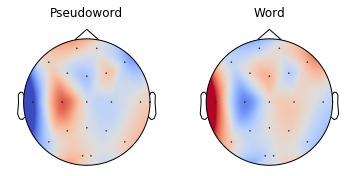

In [26]:
fs = 256
freqs = np.fft.rfftfreq(train_X_batches.shape[2], d=1.0/fs)
start_freq = 1
stop_freq = 8

i_start = np.searchsorted(freqs,start_freq)
i_stop = np.searchsorted(freqs, stop_freq) + 1

freq_corr = np.mean(amp_pred_corrs[:,i_start:i_stop], axis=1)

from braindecode.datasets.sensor_positions import get_channelpos, CHANNEL_10_20_APPROX

ch_names = [s.strip('.') for s in f.ch_names]
for i, ch_name in enumerate(ch_names):
    if ch_name == 'T3':
        ch_names[i] = 'T7'
    if ch_name == 'T4':
        ch_names[i] = 'T8'
    if ch_name == 'T5':
        ch_names[i] ='P7'
    if ch_name == 'T6':
        ch_names[i] ='P8'
print(ch_names)
positions = [get_channelpos(name, CHANNEL_10_20_APPROX) for name in ch_names]
print(positions)
positions = np.array(positions)

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
max_abs_val = np.max(np.abs(freq_corr))

fig, axes = plt.subplots(1, 2)
class_names = ['Pseudoword', 'Word']
for i_class in range(2):
    ax = axes[i_class]
    mne.viz.plot_topomap(freq_corr[:,i_class], positions,
                     vmin=-max_abs_val, vmax=max_abs_val, contours=0,
                    cmap=cm.coolwarm, axes=ax, show=False);
    ax.set_title(class_names[i_class])

['O1', 'O2', 'P7', 'P3', 'Pz', 'P4', 'P8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Fp1', 'Fp2']
[(-0.060170510847620935, -0.7347489792844866), (0.060170510847620935, -0.7347489792844866), (-0.5439282932204211, -0.543928293220421), (-0.27777777777777773, -0.392837100659193), (0.0, -0.3523015256659762), (0.27777777777777773, -0.392837100659193), (0.5439282932204211, -0.543928293220421), (-0.7692307692307692, 0.0), (-0.3523015256659762, 0.0), (0.0, 0.0), (0.3523015256659762, 0.0), (0.7692307692307692, 0.0), (-0.5439282932204211, 0.543928293220421), (-0.27777777777777773, 0.392837100659193), (0.0, 0.3523015256659762), (0.27777777777777773, 0.392837100659193), (0.5439282932204211, 0.543928293220421), (-0.14299932944506125, 0.7329903809028484), (0.14299932944506125, 0.7329903809028484)]


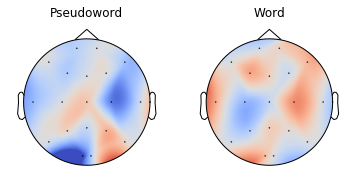

In [27]:
fs = 256
freqs = np.fft.rfftfreq(train_X_batches.shape[2], d=1.0/fs)
start_freq = 8
stop_freq = 14

i_start = np.searchsorted(freqs,start_freq)
i_stop = np.searchsorted(freqs, stop_freq) + 1

freq_corr = np.mean(amp_pred_corrs[:,i_start:i_stop], axis=1)

from braindecode.datasets.sensor_positions import get_channelpos, CHANNEL_10_20_APPROX

ch_names = [s.strip('.') for s in f.ch_names]
for i, ch_name in enumerate(ch_names):
    if ch_name == 'T3':
        ch_names[i] = 'T7'
    if ch_name == 'T4':
        ch_names[i] = 'T8'
    if ch_name == 'T5':
        ch_names[i] ='P7'
    if ch_name == 'T6':
        ch_names[i] ='P8'
print(ch_names)
positions = [get_channelpos(name, CHANNEL_10_20_APPROX) for name in ch_names]
print(positions)
positions = np.array(positions)

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
max_abs_val = np.max(np.abs(freq_corr))

fig, axes = plt.subplots(1, 2)
class_names = ['Pseudoword', 'Word']
for i_class in range(2):
    ax = axes[i_class]
    mne.viz.plot_topomap(freq_corr[:,i_class], positions,
                     vmin=-max_abs_val, vmax=max_abs_val, contours=0,
                    cmap=cm.coolwarm, axes=ax, show=False);
    ax.set_title(class_names[i_class])

['O1', 'O2', 'P7', 'P3', 'Pz', 'P4', 'P8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Fp1', 'Fp2']
[(-0.060170510847620935, -0.7347489792844866), (0.060170510847620935, -0.7347489792844866), (-0.5439282932204211, -0.543928293220421), (-0.27777777777777773, -0.392837100659193), (0.0, -0.3523015256659762), (0.27777777777777773, -0.392837100659193), (0.5439282932204211, -0.543928293220421), (-0.7692307692307692, 0.0), (-0.3523015256659762, 0.0), (0.0, 0.0), (0.3523015256659762, 0.0), (0.7692307692307692, 0.0), (-0.5439282932204211, 0.543928293220421), (-0.27777777777777773, 0.392837100659193), (0.0, 0.3523015256659762), (0.27777777777777773, 0.392837100659193), (0.5439282932204211, 0.543928293220421), (-0.14299932944506125, 0.7329903809028484), (0.14299932944506125, 0.7329903809028484)]


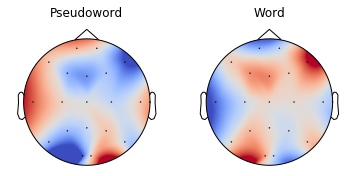

In [28]:
fs = 256
freqs = np.fft.rfftfreq(train_X_batches.shape[2], d=1.0/fs)
start_freq = 14
stop_freq = 31

i_start = np.searchsorted(freqs,start_freq)
i_stop = np.searchsorted(freqs, stop_freq) + 1

freq_corr = np.mean(amp_pred_corrs[:,i_start:i_stop], axis=1)

from braindecode.datasets.sensor_positions import get_channelpos, CHANNEL_10_20_APPROX

ch_names = [s.strip('.') for s in f.ch_names]
for i, ch_name in enumerate(ch_names):
    if ch_name == 'T3':
        ch_names[i] = 'T7'
    if ch_name == 'T4':
        ch_names[i] = 'T8'
    if ch_name == 'T5':
        ch_names[i] ='P7'
    if ch_name == 'T6':
        ch_names[i] ='P8'
print(ch_names)
positions = [get_channelpos(name, CHANNEL_10_20_APPROX) for name in ch_names]
print(positions)
positions = np.array(positions)

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
max_abs_val = np.max(np.abs(freq_corr))

fig, axes = plt.subplots(1, 2)
class_names = ['Pseudoword', 'Word']
for i_class in range(2):
    ax = axes[i_class]
    mne.viz.plot_topomap(freq_corr[:,i_class], positions,
                     vmin=-max_abs_val, vmax=max_abs_val, contours=0,
                    cmap=cm.coolwarm, axes=ax, show=False);
    ax.set_title(class_names[i_class])